In [1]:
%%capture

!pip install lightning-bolts

In [2]:
from pl_bolts.datamodules import CIFAR10DataModule
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

In [3]:
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

# Load CIFAR Data

In [4]:
datamodule = CIFAR10DataModule('.')

# Variational Autoencoder for CIFAR

In [5]:
class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32, num_classes=10):
        super().__init__()

        self.save_hyperparameters()
        # Encoder and decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )

        # Distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # For the Gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

        # Define a label embedding layer for labels
        self.label_embedding = nn.Embedding(num_classes, 512)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, y = batch  # Assuming 'y' is the label tensor
        # Transform scalar labels 'y' to one-hot encoding
        y_one_hot = F.one_hot(y, num_classes=self.hparams.num_classes).float()
        y_one_hot = torch.argmax(y_one_hot, dim=1).reshape((y_one_hot.shape[0], 1, 1, 1))
        y_one_hot = torch.ones((x.shape[0], 0, x.shape[2], x.shape[3])).to('cuda') * y_one_hot
        x = torch.cat((x, y_one_hot), dim=1)

        # Encode x to get the mu and variance parameters
        latent_space_encoding = self.encoder(x)
        mu, log_var = self.fc_mu(latent_space_encoding), self.fc_var(latent_space_encoding)

        # Sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # Decoded
        x_hat = self.decoder(z)
        # Reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)
        # KL divergence
        kl = self.kl_divergence(z, mu, std)
        # ELBO
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl_loss': kl.mean(),
            'reconstruction_loss': recon_loss.mean(),
        })

        return elbo

# Train the Model

In [6]:
# Usage
pl.seed_everything(1234)
vae = VAE(num_classes=10)  # Set the number of classes to match your dataset
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=30)
trainer.fit(vae, datamodule)

INFO:lightning_fabric.utilities.seed:Global seed set to 1234
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type          | Params
--------------------------------------------------
0 | encoder         | ResNetEncoder | 11.2 M
1 | decoder         | ResNetDecoder | 8.6 M 
2 | fc_mu           | Linear        | 131 K 
3 | fc_var          | Linear        | 131 K 
4 | label_embedding | Embedding     | 5.1 K 
--------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.249    T

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


# 25 CIFAR outputs PROPERLY Labelled and 25 CIFAR Incorrectly Labelled

Files already downloaded and verified


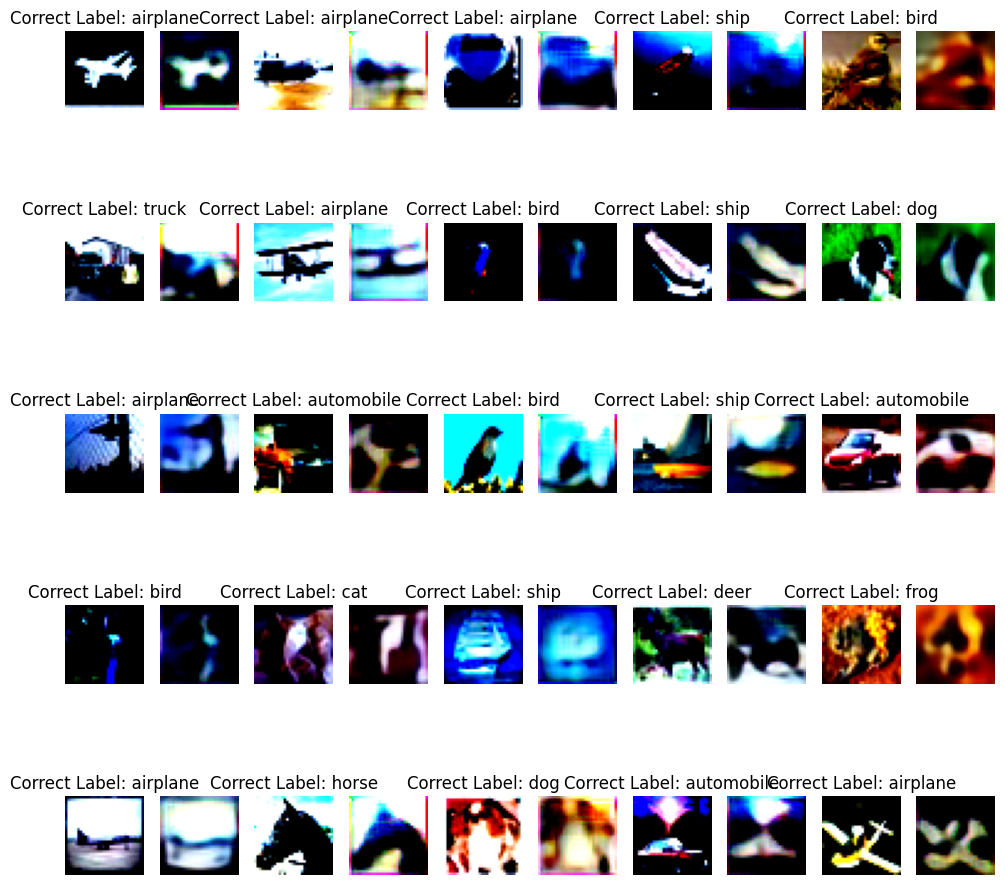

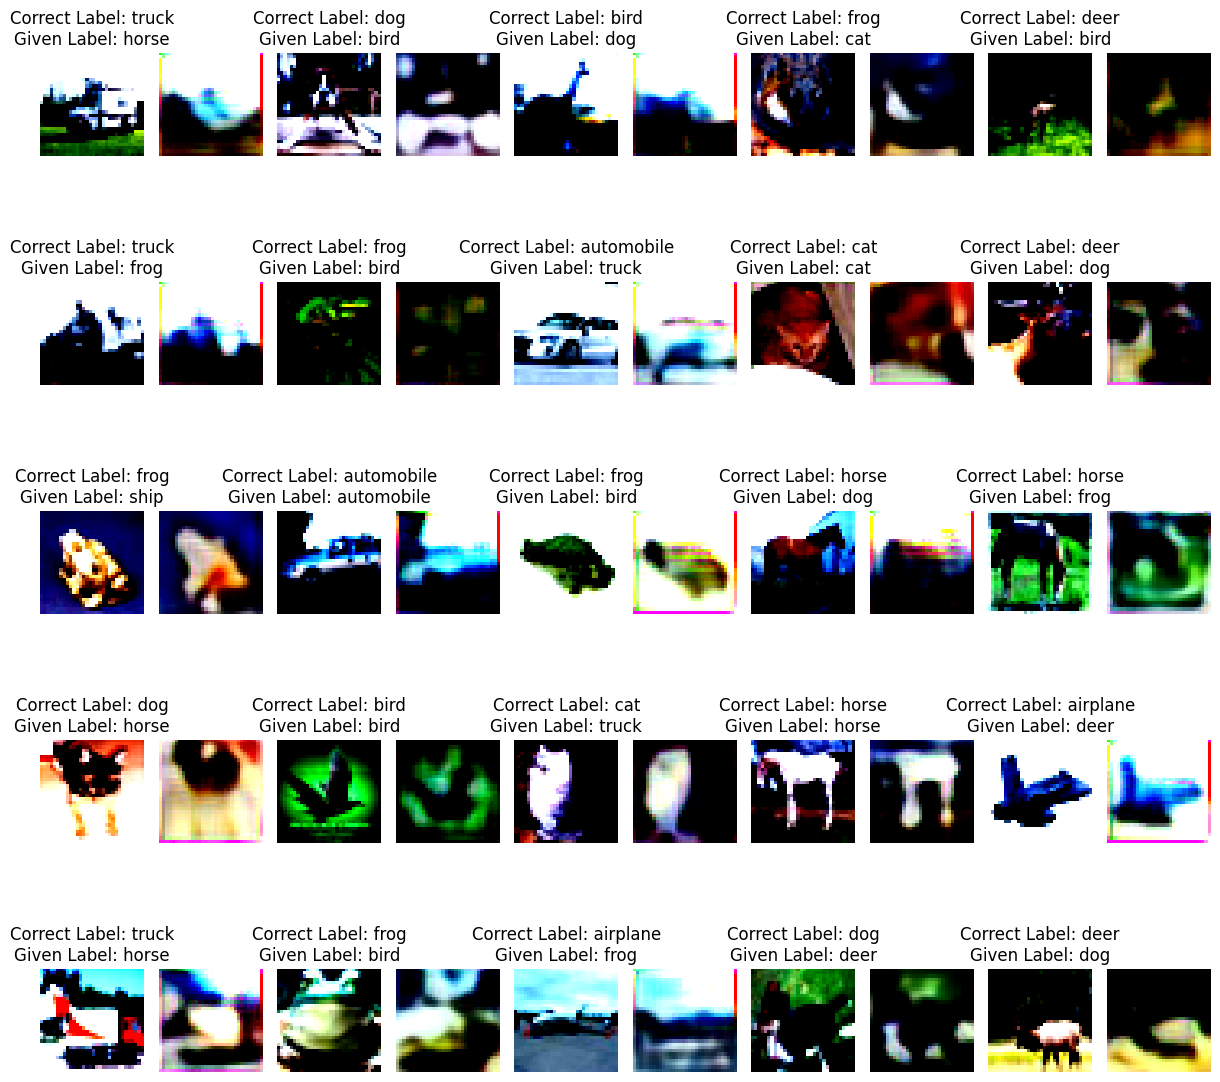

In [10]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import random

# Define a transformation for the images (assuming CIFAR-10 normalization)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.ToTensor(), normalize])

# Create the original CIFAR-10 dataset
cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Load your pre-trained VAE model (assuming 'vae' is your trained model)

# Create a DataLoader for the custom dataset with correct labels only
class CorrectLabelDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, correct_label = self.original_dataset[idx]
        return image, correct_label

custom_dataset_correct = CorrectLabelDataset(cifar10_dataset)
data_loader_correct = DataLoader(custom_dataset_correct, batch_size=1, shuffle=True)

# Create a DataLoader for the custom dataset with random incorrect labels
class IncorrectLabelDataset(Dataset):
    def __init__(self, original_dataset, incorrect_labels):
        self.original_dataset = original_dataset
        self.incorrect_labels = incorrect_labels

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, correct_label = self.original_dataset[idx]
        incorrect_label = self.incorrect_labels[idx]
        return image, correct_label, incorrect_label

# Generate random incorrect labels
incorrect_labels = [random.randint(0, 9) for _ in range(len(cifar10_dataset))]

custom_dataset_incorrect = IncorrectLabelDataset(cifar10_dataset, incorrect_labels)
data_loader_incorrect = DataLoader(custom_dataset_incorrect, batch_size=1, shuffle=True)

# Initialize lists to accumulate images and labels
images_to_plot_correct = []
images_to_plot_incorrect = []

# Assuming CIFAR-10 labels for simplicity (replace with your own labels)
cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Function to make predictions based on incorrect labels
def predict_with_incorrect_label(image, incorrect_label):
    image = image.to(vae.device)

    # Encode the image
    x_encoded = vae.encoder(image)
    mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
    std = torch.exp(log_var / 2)

    # Create a distribution based on the incorrect label
    incorrect_label_tensor = torch.tensor([incorrect_label]).float().to(vae.device)
    z = mu + std * incorrect_label_tensor  # Use incorrect_label as a factor
    x_hat = vae.decoder(z)

    return x_hat

# Loop through the dataset and make predictions with correct labels
vae.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for image, correct_label in data_loader_correct:
        correct_label = correct_label.item()

        # Encode the image and generate a prediction
        image = image.to(vae.device)
        x_encoded = vae.encoder(image)
        mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
        std = torch.exp(log_var / 2)

        # Generate a prediction
        z = mu + std * torch.randn_like(std)  # Sample from the learned distribution
        predicted_image = vae.decoder(z)

        # Accumulate images and labels
        images_to_plot_correct.append((image, predicted_image, correct_label))

        # Display up to 25 images with correct labels in a 5x5 grid
        if len(images_to_plot_correct) >= 25:
            break

# Loop through the dataset and make predictions with incorrect labels
vae.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for image, correct_label, incorrect_label in data_loader_incorrect:
        correct_label = correct_label.item()
        incorrect_label = incorrect_label.item()

        # Generate a prediction
        predicted_image = predict_with_incorrect_label(image, incorrect_label)

        # Accumulate images and labels
        images_to_plot_incorrect.append((image, predicted_image, correct_label, incorrect_label))

        # Display up to 25 pairs of actual and predicted images with incorrect labels in a 5x5 grid
        if len(images_to_plot_incorrect) >= 25:
            break

# Create a figure for the images with correct labels
num_images_correct = len(images_to_plot_correct)
num_rows = 5
num_cols = 5

plt.figure(figsize=(12, 12))
for i in range(num_images_correct):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    # Clip pixel values to the valid range [0, 1] for the actual image
    actual_image = np.clip(images_to_plot_correct[i][0].squeeze().permute(1, 2, 0).numpy(), 0, 1)
    correct_label_text = f"Correct Label: {cifar10_labels[images_to_plot_correct[i][2]]}"
    plt.imshow(actual_image)
    plt.title(correct_label_text)
    plt.axis('off')

    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    # Clip pixel values to the valid range [0, 1] for the predicted image
    predicted_image = np.clip(images_to_plot_correct[i][1].squeeze().permute(1, 2, 0).numpy(), 0, 1)
    plt.imshow(predicted_image)
    plt.axis('off')

# Create a figure for the images with incorrect labels
num_images_incorrect = len(images_to_plot_incorrect)

plt.figure(figsize=(12, 12))
for i in range(num_images_incorrect):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    # Clip pixel values to the valid range [0, 1] for the actual image
    actual_image = np.clip(images_to_plot_incorrect[i][0].squeeze().permute(1, 2, 0).numpy(), 0, 1)
    correct_label_text = f"Correct Label: {cifar10_labels[images_to_plot_incorrect[i][2]]}"
    incorrect_label_text = f"Given Label: {cifar10_labels[images_to_plot_incorrect[i][3]]}"
    plt.imshow(actual_image)
    plt.title(f"{correct_label_text}\n{incorrect_label_text}")
    plt.axis('off')

    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    # Clip pixel values to the valid range [0, 1] for the predicted image
    predicted_image = np.clip(images_to_plot_incorrect[i][1].squeeze().permute(1, 2, 0).numpy(), 0, 1)
    plt.imshow(predicted_image)
    plt.axis('off')

plt.tight_layout()
plt.show()